# Strojno učenje detekcije in prepoznave

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['figure.figsize'] = [15, 5]

import os

import scipy.ndimage as ndimage
import tensorflow as tf

# knjiznice (moduli) za gradnjo nevronske mreze keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical

# moje funkcije za nalaganje in pripravo slik, ter kompleksnejso nevronsko plast
import load_and_prep_data
from resnet_block import resnet_block

# Pretvorba slike v sliko (regresija)

Za detekcijo igralnih kock bi lahko naučili detektor, ki vrne lokacijo in velikost pravokotnika okrog kocke. Vhod je slika izhod pa je seznam 4 numeričnih vrednosti pravokotnika.

Takšna detekcija je malce zahtevnejša za učenje in razumevanje.

Namesto te, bomo uporabili preprostejši pristop. Učili bomo pretvorbo slike v drugo sliko.

Tako bi lahko učili barvanja, slikanja, iskanja robov, ... V našem primeru bomo želeli algoritem naučiti naj nad ciljne objekte nariše svetle točke. V tej sliki bomo nato poiskali vrhove teh točk in te uporabili kot lokacije kock.

#### Primeri transformacij slik

[Prenos stila med slikami](https://github.com/lengstrom/fast-style-transfer)

[Segmentacija s segnet](https://github.com/toimcio/SegNet-tensorflow)

### Lahko naučimo nevronsko mrežo detekcije robov?

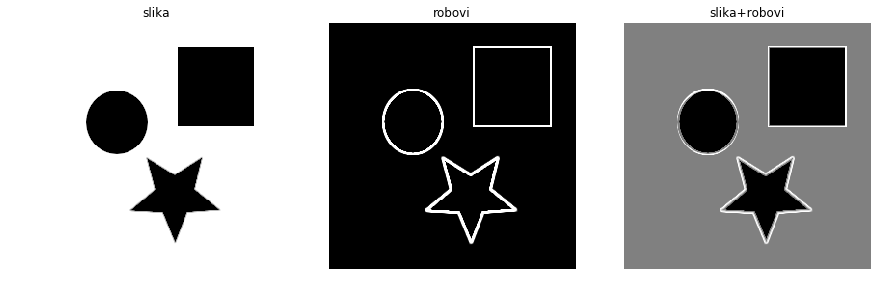

In [3]:
slika = pyplot.imread('liki.png')[:, :, 1]
slika_rob = pyplot.imread('liki_robovi.png')[:, :, 1]

pyplot.figure()
pyplot.subplot(131)
pyplot.imshow(slika)
pyplot.title('slika')
pyplot.axis('off')
pyplot.subplot(132)
pyplot.imshow(slika_rob)
pyplot.title('robovi')
pyplot.axis('off')
pyplot.subplot(133)
pyplot.imshow(slika+slika_rob)
pyplot.title('slika+robovi')
pyplot.axis('off');

#### Model nevronske mreže

* mrežo sestavimo po slojih - operacijah nad sliko
* tukaj bomo uporabili samo konvolucije
* za vsak sloj moramo navesti:
    * velikost jeder
    * število jeder
    
    
Na prvem sloju bomo uporabili 8 jeder, velikosti 11x11.

Na drugem sloju bomo imeli 1 jedro velikosti 1x1. To bo vplivalo na število izhodnih slik - z 1 jedrom bo rezultat 1 slika.

In [4]:
mreza_model = Sequential()

# dodamo prvi sloj
mreza_model.add(Conv2D(input_shape=(slika.shape[0], slika.shape[1], 1), 
                       filters=8, 
                       kernel_size=(11, 11), 
                       activation='relu', padding='same'))
# dodamo drugi sloj
mreza_model.add(Conv2D(filters=1, 
                       kernel_size=(1, 1), 
                       activation='relu', 
                       padding='same'))

# tukaj mrezo pripravimo za ucenje
mreza_model.compile(optimizer='rmsprop', loss='mse')


#### Učenje nevronske mreže

Učenje nevronske mreže vzame pripravljene učne podatke - vhodne slike in njihove cilje, ter z algoritmom nastaviti vrednosti konvolucijski jeder tako, da bi dobili željene izhode.

Ta korak je eden izmed ključnih delov strojnega učenja.

#### Najprej pripravimo podatke.

Običajno imamo pri učenju veliko število vhodnih slik in izhodnih oznak, ki jih zložimo v tabelo.

V tem primeru imamo samo eno sliko na vhodu in en pričakovan izhod, vendar moramo vseeno primerno zložiti v seznam.

In [5]:
vhodni_vzorci = slika.reshape(1, slika.shape[0], slika.shape[1], 1)
vhodni_cilji = slika_rob.reshape(1, slika.shape[0], slika.shape[1], 1)


#### Pripravimo spremljanje učenja

Učenje običajno traja dlje časa (od nekaj minut do nekaj dni).

Med tem je dobro imeti orodje za spremljanje napredka. V kolikor učenje ni uspešno želimo čimprej dobiti povratno informacijo in ga morebiti prekiniti. Knjižnici Tensorflow je zato priloženo orodje **TensorBoard**.

TensorBoard moramo pognati kot ločen program in mu povedati, kje naj najde informacije o učenju. To je sicer močno odvisno od sistema. Iz ukazne vrstice anaconde ga lahko požene iz mesta kjer izvajate to učenje (kjer ste pognali notebook) z ukazom:

```
$ tensorboard --logdir ./tf_log/
```

Tensorboard nato odprete v brskalniku na naslovu: http://localhost:6006/

V naslednjem ukazu pa konfigurirate učenje, da bo hranilo delne rezultate v ustrezno mapo.

In [6]:
# tukaj nastavimo pot, v katero se bodo hranili začasni rezultati
tb_callback = TensorBoard(log_dir='./tf_log/primer_ver1/')

#### Pričnimo učenje

Sedaj lahko poženemo učenje. Med čakanjem lahko rezultate spremljamo v tensorboard.

Pognali bomo 1000 korakov.

In [7]:
mreza_model.fit(vhodni_vzorci, vhodni_cilji, epochs=1000, batch_size=1, verbose=0, callbacks=[tb_callback]);

### Rezultat

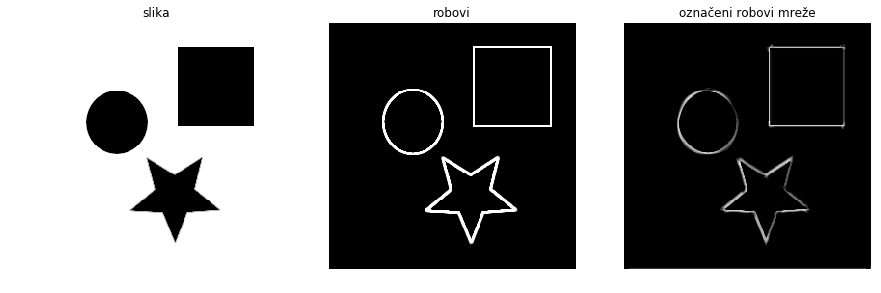

In [8]:
vhod = slika.reshape(1, slika.shape[0], slika.shape[1], 1)
izhod = mreza_model.predict(vhod)
robovi_mreze = izhod.reshape(slika.shape)

pyplot.figure()
pyplot.subplot(131)
pyplot.imshow(slika)
pyplot.title('slika')
pyplot.axis('off')
pyplot.subplot(132)
pyplot.imshow(slika_rob)
pyplot.title('robovi')
pyplot.axis('off')
pyplot.subplot(133)
pyplot.imshow(robovi_mreze)
pyplot.title('označeni robovi mreže')
pyplot.axis('off');


#### Kakšna jedra je mreža poiskala?

Najdena jedra si seveda lahko pogledamo.

Vendar je to smiselno samo na tem preprostem primeru.

Kompleksnejše mreže imajo več 1000 jeder, povezanih med sabo čez kakšnih 10 do 100 slojev.

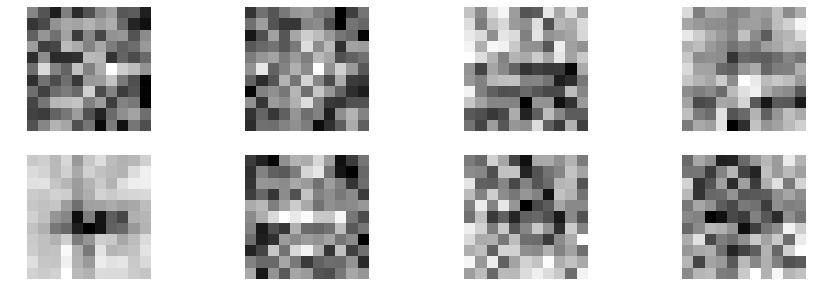

In [9]:
l0 = mreza_model.layers[0]
l0_w = l0.get_weights()[0]

fig, ax = pyplot.subplots(2, 4)
ax = ax.ravel()

for n in range(l0_w.shape[3]):
    ax[n].imshow(l0_w[..., 0, n])
    ax[n].set_axis_off()
    

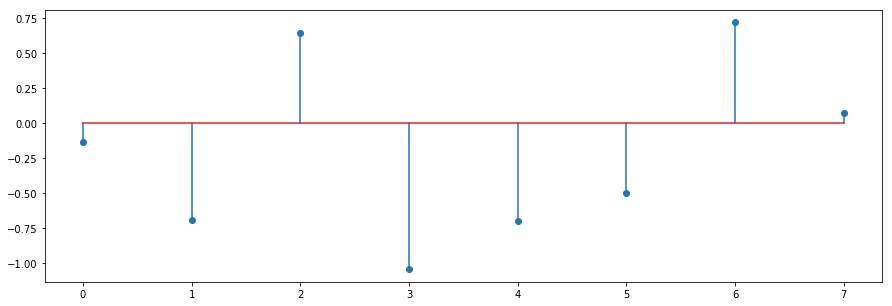

In [10]:
l1 = mreza_model.layers[1]
w = l1.get_weights()[0]

pyplot.figure()
pyplot.stem(w.ravel());

### Kaj bi želeli naučiti za detekcijo lokacije?

#### Naložimo učni primer

Pripravljenih imamo nekaj učnih slik kock v posodi.

Za vsako sliko imamo tudi označene koordinate kock.

Koordinate spremenimo v sliko oznak. Na lokaciji kocke narišemo belo točko.

In [14]:
pot_ucnih_podatkov = './data_2018_09_11/'
nalagalnik_slik = load_and_prep_data.load_imgs_from_folder(pot_ucnih_podatkov)

slike_in_imena = [(i, s) for i, s in nalagalnik_slik]
imena = [i for i, s in slike_in_imena]
slike = [s for i, s in slike_in_imena]
oznake = [load_and_prep_data.load_mask_for_image(pot_ucnih_podatkov, ime, 4.) for ime in imena]


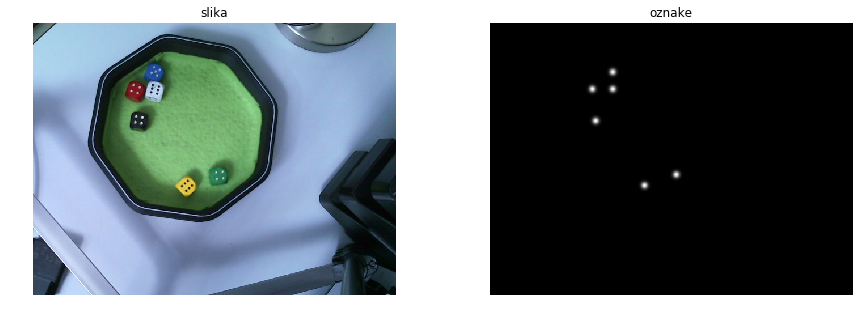

In [15]:
n = 11
slika = slike[n]
oznaka = oznake[n]
pyplot.figure()
pyplot.subplot(121)
pyplot.imshow(slika)
pyplot.title('slika')
pyplot.axis('off')
pyplot.subplot(122)
pyplot.imshow(oznaka)
pyplot.title('oznake')
pyplot.axis('off');

In [16]:

print(f'število slik: {len(slike)}')
print(f'velikost slike: {slike[0].shape}')

število slik: 51
velikost slike: (480, 640, 3)


#### Imamo majhno število slik

Potrebujemo več primerov.

Slike so tudi zelo velike, in učenje bo zahtevno.

#### Izrežemo vsako kocko posebej

Okrog vsake označene kocke lahko izrežemo okno.

Tako bomo dobili več manjših vzorcev.

In [17]:
okno = 128
nalagalnik_slik = load_and_prep_data.load_resample_and_prep_data(pot_ucnih_podatkov, win_size=okno, 
                                                                 scale_range=(1, 1), angle_range=(0,0))
slike_in_oznake = [(s, o) for s, o in nalagalnik_slik]
slike = np.array([s for s, o in slike_in_oznake])
oznake = np.array([o for s, o in slike_in_oznake])
slike[slike<0] = 0
slike_in_oznake = None


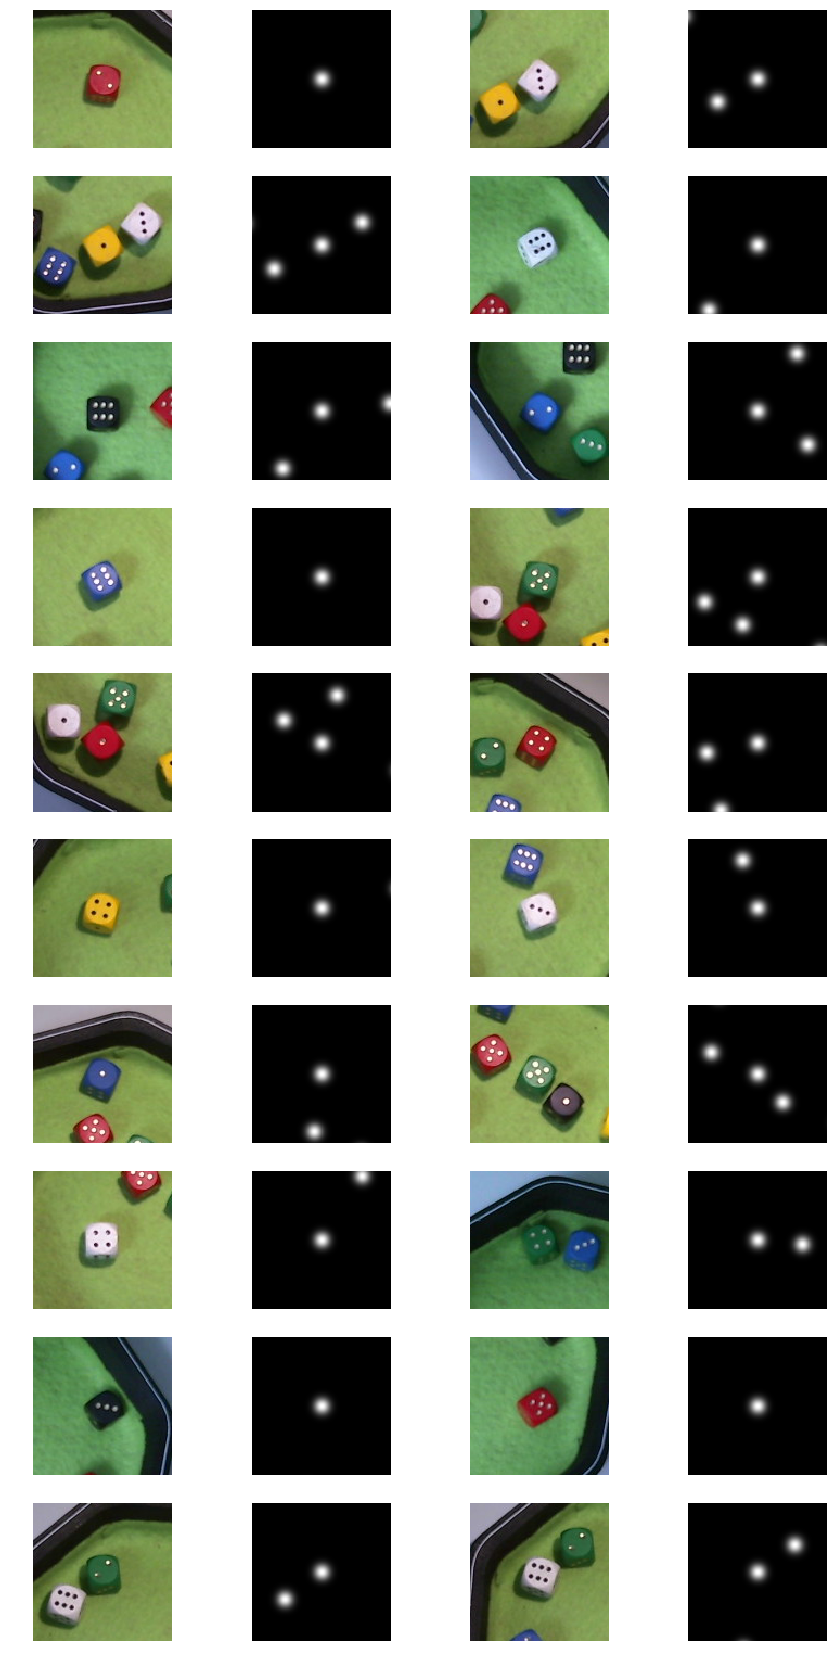

In [18]:
fig, ax = pyplot.subplots(10, 4, figsize=(15, 30))
ax = ax.ravel()
for n in range(0, ax.shape[0], 2):
    slika = slike[n]
    oznaka = oznake[n]
    ax[n].imshow(slika)
    ax[n].set_axis_off()
    ax[n+1].imshow(oznaka)
    ax[n+1].set_axis_off()

In [19]:
print(f'število primerov: {slike.shape[0]}')

število primerov: 306


Število vzorcev je še vedno manjše, kot bi si želeli.

#### Modifikacija vzorcev

Iz posnetkov lahko umetno generiramo nove vzorce, če slike malce deformiramo.

Pri tem je pomembno, da uporabimo deformacije, ki so za nas smiselne.

V tem primeru smo uporabili:

* spremembo velikost
* rotacijo

Iz vsakega posnetka kocke smo generirali 10 novih primerov.

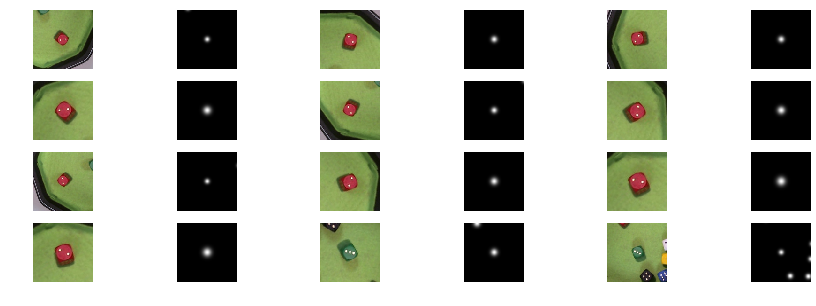

In [20]:
okno = 128
nalagalnik_slik = load_and_prep_data.load_resample_and_prep_data(pot_ucnih_podatkov, 
                                                                 resamples=10, win_size=okno,
                                                                scale_range=(0.6, 1.4))
fig, ax = pyplot.subplots(4, 6)
ax = ax.ravel()
for n in range(0, ax.shape[0], 2):
    slika, oznaka = nalagalnik_slik.__next__()
    slika[slika<0] = 0
    slika[slika>1] = 1
    ax[n].imshow(slika)
    ax[n].set_axis_off()
    ax[n+1].imshow(oznaka)
    ax[n+1].set_axis_off()

Število vzorcev bi sedaj bilo 10x večje: 3060.

Ta številka še vedno ni zelo velika, v dejanski učni množici smo uporabili ~50.000 primerkov iz ~300 unikatnih posnetkov. 

Vendar bomo za to demonstracijo ostali na tej številki.

#### Kompleksna mreža?

Za detekcijo in prepoznavo bomo potrebovali bolj kompleksno mrežo, kot smo jo uporabili v začetnem primeru.

To bo sicer podaljšalo učenje in uporabo, vendar bo omogočilo dobro delovanje.

In [21]:
def conv_net_model(features, labels, mode):
    # Input Layer
    N, H, W, C = features['x'].shape
    input_layer = tf.reshape(features['x'], [-1, H, W, C])

    # are we training?
    training = mode==tf.estimator.ModeKeys.TRAIN

    kernel_size = (5, 5) # velikost jeder
    layer_count = 5 # stevilo slojev v resnet, konvolucijskih slojev je 2x toliko
    filters = 8 # stevilo jeder v vsakem sloju
    
    # izracun roba, ki se ne uposteva pri racunanju napake
    # receptive field -  5+10*(2+2) = 45
    # invalid edge - (45-1)/2 = 22 
    E = 22

    # vhodni sloj
    prev_layer = tf.layers.conv2d(inputs=input_layer,
                                  filters=filters,
                                  kernel_size=kernel_size,
                                  padding='same',
                                  name='conv_1')

    # resnet sloji
    resnet_layers_dict = {}
    for l in range(layer_count):
        res_layer = resnet_block(inputs=prev_layer, 
        		     training=training,
        		     kernel_size=kernel_size,
        		     filters=filters,
        		     name=f'res_layer{l+1:d}')
        resnet_layers_dict[f'res_layer{l+1:d}'] = res_layer
        prev_layer = res_layer
    relu_top = tf.nn.relu(res_layer, 
    		      name='relu_top')
    
    # izhodni sloj, tu sta dve sliki
    # kjer prva slika pove kje ni kocke
    # druga pa kje kocka je
    output_map = tf.layers.conv2d(inputs=relu_top,
                                  filters=2,
                                  kernel_size=(1, 1),
                                  name='output_logits')
        
    
    # od te tocke dalje ni vec novih slojev mreze
    # samo se konfiguracija ucenja in ocenjevanje 
    
    predictions = {
        # Generate prediction map
        'map': output_map#tf.nn.softmax(output_map, axis=3)
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions['input'] = input_layer
        predictions.update(resnet_layers_dict)
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    target_map = tf.reshape(labels, [-1, H, W, 2])
    target_probs = tf.reshape(target_map[:, E:-E, E:-E, :], (-1, 2))
    logits = tf.reshape(output_map[:, E:-E, E:-E, :], (-1, 2))

    # calculate weights to fix uneven class representation
    w1 = tf.reduce_mean(target_probs)
    class_weights = tf.stack([w1, 1-w1], axis=0, name='class_weights')
    weights = tf.gather(class_weights, tf.argmax(target_probs, axis=1))

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.softmax_cross_entropy(onehot_labels=target_probs, logits=logits, weights=weights)


    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        tf.summary.image('input_summary', input_layer)
        #tf.summary.image('weights_summary', tf.reshape(weights, [-1, H, W, 1]))
        tf.summary.image('target_summary', target_map[:, :, :, 1:2])
        tf.summary.image('output_summary', predictions['map'][:, :, :, 1:2])

        global_step = tf.train.get_global_step()
        learning_rate = tf.train.exponential_decay(0.01,
                                                   global_step,
                                                   10000,
                                                   0.8,
                                                   staircase=True,
                                                   name='learning_rate')
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(
                loss=loss,
                global_step=tf.train.get_global_step())

        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    #(for EVAL mode,  the only remaining mode)
    # Add evaluation metrics 
    eval_metric_ops = {
        'accuracy': tf.metrics.accuracy(
            labels=tf.argmax(target_map[:, E:-E, E:-E, :], axis=3), 
            predictions=tf.argmax(predictions['map'][:, E:-E, E:-E, :], axis=3))
    }

    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

#### Pripravimo si mapo za naš model

In [22]:
model_dir = 'tf_log/kocke_detekcija_ver1/'
try:
    os.mkdir(model_dir)
except:
    pass

#### Naložimo in pripravimo učne podatke

To smo sicer naredili že prej, vendar je metoda tukaj malce drugačna in prilagojena za učenje te mreže.

Ker je naključno generiranje zamudno, ta metoda tudi shrani slike, po tem ko jih enkrat pripravimo, in jih kasneje le ponovno naloži.

In [23]:
tmp_data_file = os.path.join(model_dir, 'tmp_data.npz')
if os.path.isfile(tmp_data_file): # v kolikor smo slike ze hranili jih samo nalozimo
    data = np.load(tmp_data_file)###3
    imgs = data['imgs']
    masks = data['masks']
    data = None
else: # drugace jih moramo generirati in nato shraniti
    data = list(load_and_prep_data.load_resample_and_prep_data('./data_2018_09_11/', win_size=128, resamples=10))
    imgs = np.array([i for i, _ in data])
    masks = np.array([m for _, m in data])
    data = None
    np.savez(tmp_data_file, imgs=imgs, masks=masks)

#### Podatke je potrebno razdeliti in pripraviti

Naše učne primere moramo razdeliti v dve skupini. 

Eno za učenje.

In eno za preizkušanje (validacijo). 

In [24]:
print('sample array size: {:}'.format(imgs.shape))
imgs[imgs<0] = 0
imgs[imgs>1] = 1
masks[masks<1e-5] = 1e-5
masks[masks>1-1e-5] = 1-1e-5

target_maps = np.zeros(masks.shape+(2,), dtype=np.float32)
target_maps[..., 0] = 1-masks
target_maps[..., 1] = masks

test_sample_mask = np.zeros(imgs.shape[0], dtype=np.bool8)
test_sample_mask[-(6*16*3):] = True

imgs_train = imgs[test_sample_mask==False]
target_maps_train = target_maps[test_sample_mask==False]

imgs_test = imgs[test_sample_mask]
target_maps_test = target_maps[test_sample_mask]

train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'x': imgs_train},
        y=target_maps_train,
        batch_size=8,
        num_epochs=None,
        shuffle=True)

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'x': imgs_test},
        y=target_maps_test,
        num_epochs=1,
        shuffle=False)


sample array size: (3060, 128, 128, 3)


#### Pripravimo nevronsko mrežo

In [25]:
cnn_model_fn = conv_net_model
tf_estimator = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir=model_dir)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tf_log/kocke_detekcija_ver1/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbf4aa982b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


#### Izvedimo učenje

In [26]:
for n in range(1):
    tf_estimator.train(
            input_fn=train_input_fn,
            steps=1000)

    eval_results = tf_estimator.evaluate(input_fn=eval_input_fn)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into tf_log/kocke_detekcija_ver1/model.ckpt.
INFO:tensorflow:loss = 0.7720785, step = 1
INFO:tensorflow:global_step/sec: 2.64164
INFO:tensorflow:loss = 0.061362036, step = 101 (37.870 sec)
INFO:tensorflow:global_step/sec: 3.67337
INFO:tensorflow:loss = 0.055637676, step = 201 (27.209 sec)
INFO:tensorflow:global_step/sec: 3.87529
INFO:tensorflow:loss = 0.049175024, step = 301 (25.804 sec)
INFO:tensorflow:global_step/sec: 3.39221
INFO:tensorflow:loss = 0.03863267, step =

## Prepoznava vrednosti (klasifikacija)

Namesto lokacije bomo sedaj morali označiti vrednosti.

#### Kako prilagodimo nevronsko mrežo?

Napovedovali bomo razred (problem klasifikacije).

Vsaka možna vrednost od 1 do 6 je en razred.

Vsak razred ima en izhod na mreži - skupaj 6 izhodov, zloženih v tabelo.

Visoka vrednost pomeni, da je na sliki ustrezen razred. Nizka pomeni da ni.

Temu primerno moramo označiti tudi učne vzorce.

#### Pripravimo mapo

In [27]:
model_dir = 'tf_log/kocke_prepoznava_ver2/'
try:
    os.mkdir(model_dir)
except:
    print('WARNING: model directory already exists')
    pass

#### Učni primeri

Podobno kot prej, tudi tu najprej vzorce generiramo in hranimo. Ob kasnejṡih zagonih jih le naložimo.


In [28]:
tmp_data_file = os.path.join(model_dir, 'tmp_data.npz')
if os.path.isfile(tmp_data_file):
    data = np.load(tmp_data_file)
    train_imgs = data['train_imgs']
    train_labels = data['train_labels']
    eval_imgs = data['eval_imgs']
    eval_labels = data['eval_labels']
else:
    print('generiranje vzorcev')
    img_val_list = [(img, val) for img, _, val in \
                     load_and_prep_data.load_resample_and_prep_dice_data_from_folders(\
                     ['./data_2018_09_11'],\
                     resamples=10, trans_range=(-4, 4))]
    
    imgs = np.array([img for img,_ in img_val_list])
    vals = np.array([val for _,val in img_val_list])
    
    imgs[imgs<0] = 0
    imgs[imgs>1] = 1
    
    N = imgs.shape[0]
    train_imgs = imgs[:(N*2)//3]
    train_labels = vals[:(N*2)//3]-1
    eval_imgs = imgs[(N*2)//3:]
    eval_labels = vals[(N*2)//3:]-1
    
    del img_val_list
    np.savez(tmp_data_file, train_imgs=train_imgs,
                            eval_imgs=eval_imgs,
                            train_labels=train_labels,
                            eval_labels=eval_labels)

# vrednosti moramo preoblikovati v tabele 6 vrednosti, tista ki jo iščemo je nastavljena na 1
train_labels_cat = to_categorical(train_labels, 6)
eval_labels_cat = to_categorical(eval_labels, 6)

print(f'število učnih vzorcev:   {train_imgs.shape[0]}')
print(f'število testnih vzorcev: {eval_imgs.shape[0]}')

generiranje vzorcev
število učnih vzorcev:   2040
število testnih vzorcev: 1020


#### Pogljemo si vzorce

Pri generiranju pa sedaj poleg rotiranja in skaliranja dodamo še manjše premike. 

To simulira napake v detekciji, kjer se pogosto zmotimo za nekaj pikslov.

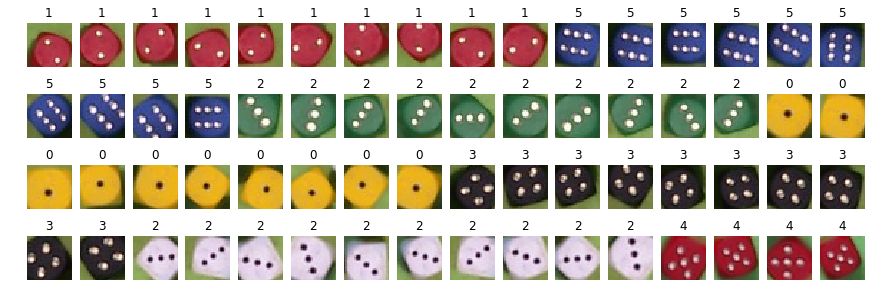

In [29]:
fig, ax = pyplot.subplots(4, 16)
ax = ax.ravel()
for n in range(0, ax.shape[0]):
    ax[n].imshow(train_imgs[n])
    ax[n].set_title(f'{train_labels[n]}')
    ax[n].set_axis_off()

#### Pripravimo model nevronske mreže

Dodamo nekaj slojev konvolucije.

* število filtrov pada: 16, 8, 4
* velikost jeder 5x5

Na vrhu sliko sploščimo - spremenimo sliko v 1D tabelo.

Nato polno povezan sloj, ki zmanjša preostalo število vrednosti na 6. 

Teh 6 bo predstavljajo 6 izhodov za napovedovanje 6 vrednosti.

In [30]:
mreza_model = Sequential()

# dodamo sloje
mreza_model.add(Conv2D(input_shape=train_imgs.shape[1:], filters=16, 
                       kernel_size=(5, 5), activation='relu'))
mreza_model.add(Conv2D(filters=8, kernel_size=(5, 5), activation='relu'))
mreza_model.add(Conv2D(filters=4, kernel_size=(5, 5), activation='relu'))
mreza_model.add(Flatten()) # tukaj sliko spremenimo v 1D tabelo
mreza_model.add(Dense(6, activation='softmax')) # tukaj dodamo sloj za klasifikacijo v 6 razredov

# tukaj mrezo pripravimo za ucenje
mreza_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
tb_callback = TensorBoard(log_dir=model_dir)

#### Pričnimo z učenjem mreže

In [31]:
mreza_model.fit(train_imgs, train_labels_cat, epochs=10, batch_size=1, 
                verbose=1, validation_data=(eval_imgs, eval_labels_cat),
                callbacks=[tb_callback])

Train on 2040 samples, validate on 1020 samples
Epoch 1/10
2040/2040 [==============================] - 15s 7ms/step - loss: 1.7888 - acc: 0.1819 - val_loss: 1.8028 - val_acc: 0.1569
Epoch 2/10
2040/2040 [==============================] - 17s 8ms/step - loss: 1.7845 - acc: 0.1912 - val_loss: 1.8097 - val_acc: 0.1569
Epoch 3/10
2040/2040 [==============================] - 14s 7ms/step - loss: 1.7844 - acc: 0.1912 - val_loss: 1.8126 - val_acc: 0.1569
Epoch 4/10
2040/2040 [==============================] - 14s 7ms/step - loss: 1.7844 - acc: 0.1912 - val_loss: 1.8152 - val_acc: 0.1569
Epoch 5/10
2040/2040 [==============================] - 14s 7ms/step - loss: 1.7846 - acc: 0.1907 - val_loss: 1.8166 - val_acc: 0.1569
Epoch 6/10
2040/2040 [==============================] - 15s 7ms/step - loss: 1.7848 - acc: 0.1912 - val_loss: 1.8180 - val_acc: 0.1569
Epoch 7/10
2040/2040 [==============================] - 14s 7ms/step - loss: 1.7849 - acc: 0.1912 - val_loss: 1.8164 - val_acc: 0.1569
Epoch 8